# Visualize differences in CDS & Pseudogene counts - Bakta vs PGAP

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd


## Part 1: Parse TSV comparing annotated features between PGAP and Bakta
#### (N = 151 Mtb hybrid assemblies)

In [4]:
annot_comparison_df = pd.read_csv('Data/pgap_and_bakta_comparison_stats.151CI.tsv',
                                  sep='\t')
annot_comparison_df.shape

(151, 9)

In [5]:
annot_comparison_df.head(4)

,Isolate,Bakta_proteincoding,Bakta_pseudogenes,Bakta_RNAgenes,Bakta_total,PGAP_proteincoding,PGAP_pseudogenes,PGAP_RNAgenes,PGAP_total
0,N0072,4041,11,71,4123,3903,356,49,4308
1,N0153,4028,14,71,4113,3872,388,49,4309
2,TB3113,4077,7,72,4156,3916,382,49,4347
3,TB1236,4065,8,72,4145,3925,370,49,4344


In [9]:
(annot_comparison_df["PGAP_pseudogenes"] / annot_comparison_df["PGAP_total"]).describe()

count    151.000000
mean       0.086110
std        0.008588
min        0.070005
25%        0.078563
50%        0.086417
75%        0.091389
max        0.106964
dtype: float64

In [10]:
(annot_comparison_df["Bakta_pseudogenes"] / annot_comparison_df["Bakta_total"]).describe()

count    151.000000
mean       0.002173
std        0.000723
min        0.001201
25%        0.001688
50%        0.002158
75%        0.002416
max        0.007481
dtype: float64

#### 0.1% - 0.7%

In [7]:
annot_comparison_df["PGAP_pseudogenes"].describe()

count    151.000000
mean     373.774834
std       38.969761
min      302.000000
25%      339.000000
50%      376.000000
75%      396.000000
max      470.000000
Name: PGAP_pseudogenes, dtype: float64

In [8]:
annot_comparison_df["Bakta_pseudogenes"].describe()

count    151.000000
mean       9.019868
std        3.003265
min        5.000000
25%        7.000000
50%        9.000000
75%       10.000000
max       31.000000
Name: Bakta_pseudogenes, dtype: float64

## Part 2: Calculate table of summary stats (PGAP vs Bakta)

In [4]:
#The following code calculates the median and IQR for each feature type for both PGAP and Bakta.

#function to calculate IQR
def calculate_iqr(series):
    return series.quantile(0.75) - series.quantile(0.25)

feature_types = ['proteincoding', 'pseudogenes', 'RNAgenes', 'total']

#initializing a dictionary to hold the summary statistics
summary_stats = {'Feature': [],
                 'PGAP_Median': [], 'PGAP_IQR': [], 'PGAP_Q1': [], 'PGAP_Q3': [],
                 'Bakta_Median': [], 'Bakta_IQR': [], 'Bakta_Q1': [], 'Bakta_Q3': [],}

for feature in feature_types:
    summary_stats['Feature'].append(feature.capitalize())
    summary_stats['PGAP_Median'].append(annot_comparison_df[f'PGAP_{feature}'].median())
    summary_stats['PGAP_IQR'].append(calculate_iqr(annot_comparison_df[f'PGAP_{feature}']))
    summary_stats['PGAP_Q1'].append(annot_comparison_df[f'PGAP_{feature}'].quantile(0.25))
    summary_stats['PGAP_Q3'].append(annot_comparison_df[f'PGAP_{feature}'].quantile(0.75))

    summary_stats['Bakta_Median'].append(annot_comparison_df[f'Bakta_{feature}'].median())
    summary_stats['Bakta_IQR'].append(calculate_iqr(annot_comparison_df[f'Bakta_{feature}']))
    summary_stats['Bakta_Q1'].append(annot_comparison_df[f'Bakta_{feature}'].quantile(0.25))
    summary_stats['Bakta_Q3'].append(annot_comparison_df[f'Bakta_{feature}'].quantile(0.75))

AnnoSummary_df = pd.DataFrame(summary_stats)

AnnoSummary_df


,Feature,PGAP_Median,PGAP_IQR,PGAP_Q1,PGAP_Q3,Bakta_Median,Bakta_IQR,Bakta_Q1,Bakta_Q3
0,Proteincoding,3919.0,30.0,3900.0,3930.0,4067.0,22.5,4057.0,4079.5
1,Pseudogenes,376.0,57.0,339.0,396.0,9.0,3.0,7.0,10.0
2,Rnagenes,49.0,0.0,49.0,49.0,72.0,1.0,71.0,72.0
3,Total,4340.0,35.5,4320.0,4355.5,4147.0,22.5,4138.0,4160.5


## Part 3: Generate boxplots comparing annotation types - PGAP vs Bakta

In [5]:
!mkdir Results3_Plots/

mkdir: cannot create directory ‘Results3_Plots/’: File exists


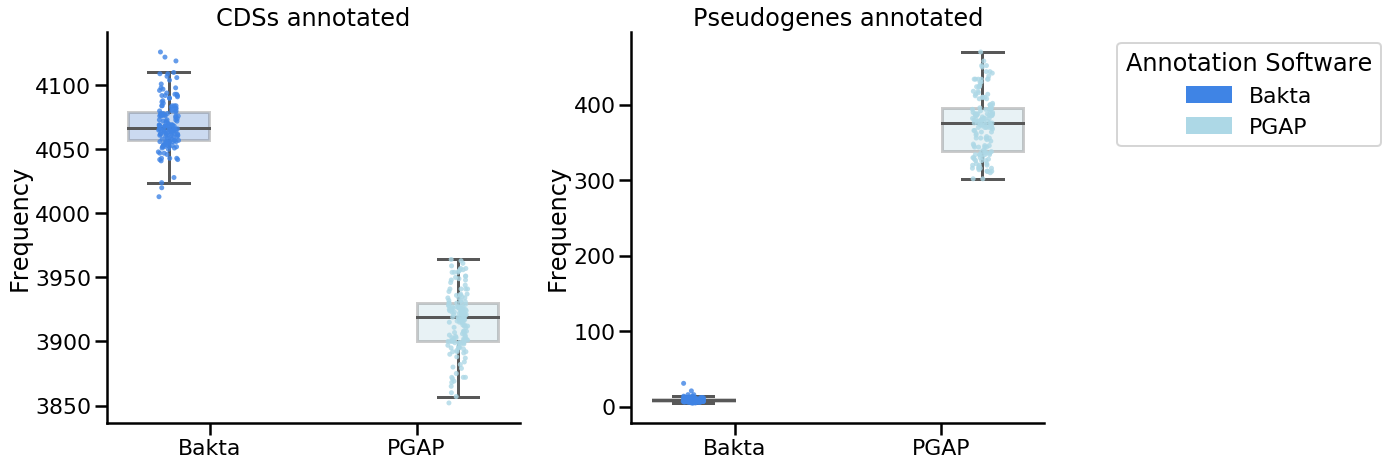

In [6]:
sns.set_context("poster")

#melting dataframe to long format for use with seaborn's boxplot
df_melted = annot_comparison_df.melt(id_vars='Isolate', var_name='Annotation_Type', value_name='Count')

#splitting 'Annotation_Type' into 'Software' and 'Feature' for grouping in the plot
df_melted[['Software', 'Feature']] = df_melted['Annotation_Type'].str.split('_', expand=True)

df_melted = df_melted[~df_melted['Feature'].str.contains('total', case=False)]
df_melted["Feature"] = df_melted["Feature"].replace("proteincoding", "CDSs").replace("RNAgenes", "RNAs").replace("pseudogenes", "Pseudogenes")

df_melted = df_melted.query("Feature != 'RNAs'")

features = df_melted['Feature'].unique()

#creating a subplot for each feature type with independent y-axes
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 7), sharey=False)

pallete_ForPlot = ["#3F84E5", "#ADD8E6"]


#plotting each feature type in its own subplot with seaborn boxplot and stripplot
for ax, feature in zip(axes, features):
    feature_data = df_melted[df_melted['Feature'] == feature]
    sns.boxplot(
        data=feature_data, 
        x='Software', y='Count', hue='Software', palette=pallete_ForPlot, boxprops=dict(alpha=.3), fliersize=0, ax=ax, 
    )
    sns.stripplot(
        data=feature_data,
        x='Software', y='Count', hue='Software', jitter=True, marker='o', alpha=0.8, edgecolor='gray',
        ax=ax, dodge=True, palette = pallete_ForPlot
    )
    ax.set_title(f'{feature} annotated')
    #ax.set_xlabel('Feature Type')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    sns.despine(ax=ax)

    #only show the legend for the last plot
    if ax != axes[-1]:
        ax.get_legend().remove()

#axes[-1].legend(title='Annotation Software', loc='upper right')

Bakta_patch = mpatches.Patch(color="#3F84E5", label='Bakta')
PGAP_patch = mpatches.Patch(color = "#ADD8E6", label='PGAP')

ax.legend(title = "Annotation Software", handles=[Bakta_patch, PGAP_patch], bbox_to_anchor=(1.15, 1)) 


#adjusting layout to prevent overlap
plt.tight_layout()

plt.savefig("Results3_Plots/3.AnnoFeatures.BaktaVsPGAP.2Boxplots.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results3_Plots/3.AnnoFeatures.BaktaVsPGAP.2Boxplots.svg", bbox_inches="tight")

plt.show()

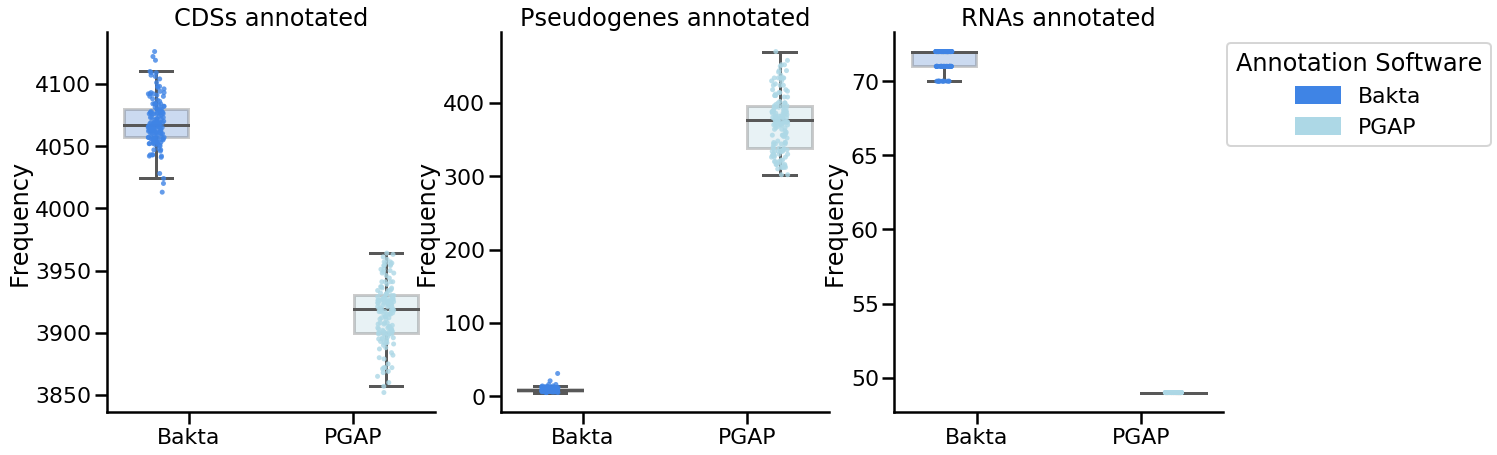

In [7]:
sns.set_context("poster")

#melting dataframe to long format for use with seaborn's boxplot
df_melted = annot_comparison_df.melt(id_vars='Isolate', var_name='Annotation_Type', value_name='Count')

#splitting 'Annotation_Type' into 'Software' and 'Feature' for grouping in the plot
df_melted[['Software', 'Feature']] = df_melted['Annotation_Type'].str.split('_', expand=True)

df_melted = df_melted[~df_melted['Feature'].str.contains('total', case=False)]
df_melted["Feature"] = df_melted["Feature"].replace("proteincoding", "CDSs").replace("RNAgenes", "RNAs").replace("pseudogenes", "Pseudogenes")


features = df_melted['Feature'].unique()

#creating a subplot for each feature type with independent y-axes
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 7), sharey=False)

pallete_ForPlot = ["#3F84E5", "#ADD8E6"]


#plotting each feature type in its own subplot with seaborn boxplot and stripplot
for ax, feature in zip(axes, features):
    feature_data = df_melted[df_melted['Feature'] == feature]
    sns.boxplot(
        data=feature_data, 
        x='Software', y='Count', hue='Software', palette=pallete_ForPlot, boxprops=dict(alpha=.3), fliersize=0, ax=ax, 
    )
    sns.stripplot(
        data=feature_data,
        x='Software', y='Count', hue='Software', jitter=True, marker='o', alpha=0.8, edgecolor='gray',
        ax=ax, dodge=True, palette = pallete_ForPlot   
    )
    ax.set_title(f'{feature} annotated')
    #ax.set_xlabel('Feature Type')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    sns.despine(ax=ax)

    #only show the legend for the last plot
    if ax != axes[-1]:
        ax.get_legend().remove()

Bakta_patch = mpatches.Patch(color="#3F84E5", label='Bakta')
PGAP_patch = mpatches.Patch(color = "#ADD8E6", label='PGAP')

ax.legend(title = "Annotation Software", handles=[Bakta_patch, PGAP_patch], bbox_to_anchor=(1.85, 1)) 

#adjusting layout to prevent overlap
#plt.tight_layout()

#plt.savefig("Results3_Plots/3.AnnoFeatures.BaktaVsPGAP.3Boxplots.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.AnnoFeatures.BaktaVsPGAP.3Boxplots.svg", bbox_inches="tight")

plt.show()

In [8]:
annot_comparison_df.head(5)

,Isolate,Bakta_proteincoding,Bakta_pseudogenes,Bakta_RNAgenes,Bakta_total,PGAP_proteincoding,PGAP_pseudogenes,PGAP_RNAgenes,PGAP_total
0,N0072,4041,11,71,4123,3903,356,49,4308
1,N0153,4028,14,71,4113,3872,388,49,4309
2,TB3113,4077,7,72,4156,3916,382,49,4347
3,TB1236,4065,8,72,4145,3925,370,49,4344
4,TB2659,4065,8,72,4145,3922,370,49,4341


In [9]:
df_melted["Feature"].value_counts()

CDSs           302
Pseudogenes    302
RNAs           302
Name: Feature, dtype: int64

In [10]:
df_melted.head(5)

,Isolate,Annotation_Type,Count,Software,Feature
0,N0072,Bakta_proteincoding,4041,Bakta,CDSs
1,N0153,Bakta_proteincoding,4028,Bakta,CDSs
2,TB3113,Bakta_proteincoding,4077,Bakta,CDSs
3,TB1236,Bakta_proteincoding,4065,Bakta,CDSs
4,TB2659,Bakta_proteincoding,4065,Bakta,CDSs
